# IMB tests

Results from Intel MPI benchmarks.

In [1]:
import os, sys
from pprint import pprint
from pathlib import Path

REPO_ROOT = str(Path(os.getcwd()).parent.parent.parent.parent)  # Repo root dir
REFRAME_ROOT = os.path.join(REPO_ROOT, 'reframe')  # ReFrame root dir
REFRAME_DEPS = os.path.join(REFRAME_ROOT, 'external')  # ReFrame dependencies
REPO_DEPS = os.path.join(REPO_ROOT, 'external')  # Repo dependencies
PERFLOG_DIR = os.path.join(REPO_ROOT, 'perflogs')  # Perflogs dir
sys.path.extend((REFRAME_ROOT, REPO_ROOT, REPO_DEPS, REFRAME_DEPS)) # the `modules` package imports `reframe` so need that in sys.modules

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import modules
from reframe_config import site_configuration

# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter
from IPython.display import display, HTML

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [3]:
# Constants and conversions
B2KiB = 1024
Gb2MB = 125

## Systems and their descriptions

The following table gives a high level overview of each partition defined in terms of architecture and configuration. The column `S:C:T` stands for **number of sockets**, **number of physical cores per socket** and **number of threads per core**. Similarly, the column `caches` indicate the cache sizes from lower to higher in bytes.

In [4]:
df = modules.utils.tabulate_partitions(root=PERFLOG_DIR)
display(HTML(df.transpose().to_html()))

## Benchmarks

By default following benchmarks are executed:

- Pingpong
- Uniband
- Biband
- Allgather
- Alltoall
- Allreduce

Each benchmark except Pingpong is executed in two modes:

- One MPI process per node
- As many MPI processes as there are physical cores per node

While Pingpong benchmark is always executed on 2 nodes with 1 MPI process per node, the rest of the benchmarks can be executed on any number of nodes. 

## Maximum bandwidths for Pingpong, Uniband and Biband benchmarks

The table shows the maximum bandwidths obtained amongst all message sizes for Pingpong, Uniband and Biband benchmarks. For the values shown in the following table, we use benchmark tests from only 2 nodes.

All the values are represented as percentage of line-rates for the interconnect. An entry `interconnect_line_rate` must be present in `extras` for each system partition in `reframe_config.py`.

In [5]:
def get_system_interconnect_speed(system, partition):
    for s in site_configuration['systems']:
        if s['name'] == system:
            for p in s['partitions']:
                if p['name'] == partition:
                    try:
                        return p['extras']['interconnect']
                    except KeyError:
                        return None

linerates = {}
for test_name, perf_name, perf_pat in [('ImbPingpongTest', 'PingPong', 'PingPong_bw_*'), 
                                       ('ImbAllCoreTests_2','Uniband', 'Uniband_bw_*'), 
                                       ('ImbAllCoreTests_2','Biband', 'Biband_bw_*')]:
    linerates[perf_name] = {}
    df = modules.utils.tabulate_last_perf(test=test_name,
                                              root=PERFLOG_DIR,
                                              extras=[])
    df = df.filter(regex=(perf_name), axis=0)
    for c in df.columns:
        max_bw = df[c].max(axis=0)
        system, partition, _ = c.split(':')
        speed = get_system_interconnect_speed(system, partition)
        if speed is not None:
            speed = Gb2MB * int(speed)  # Speed is always in Gb/s in reframe config file
        else:
            print(f'WARNING: Interconnect speed not found for {c}')
            speed = max_bw
        linerates[perf_name][c] =  max_bw / speed
        if 'Bi' in perf_name:
            linerates[perf_name][c] = linerates[perf_name][c] / 2
display(pd.DataFrame(linerates))

PingPong   Uniband    Biband
grenoble-g5k:dahu-gcc9-ompi4-opa-umod:imb    0.944237  0.993018  0.984108
juwels-cluster:batch-gcc9-ompi4-ib-umod:imb  0.929210  0.962073  0.961883

## Results of pingpong, uniband and biband

The plots show the following results:

- Bandwidth and latency for Pingpong test with message size
- Bandwidth of Uniband and Biband tests with message size

Both results are plotted for the case of 2 processes runs, _i.e.,_ using 2 nodes and 1 MPI process per node. Results are for the most-recent test on each system/partition/environment combination.

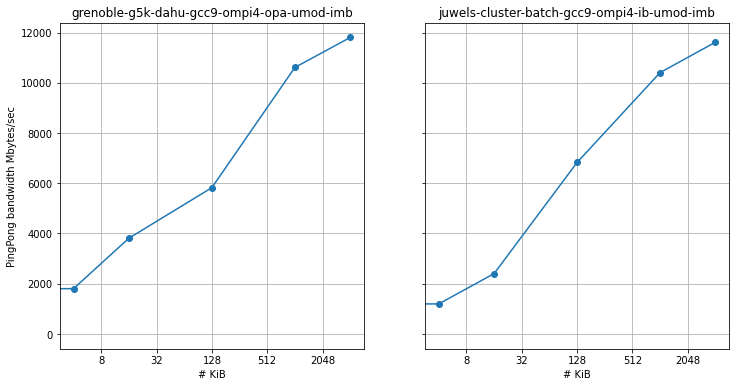

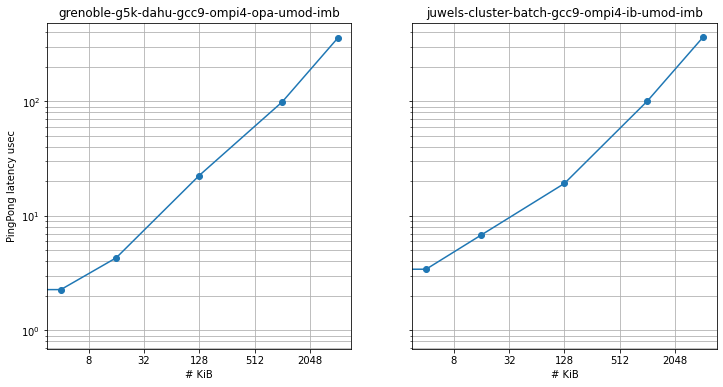

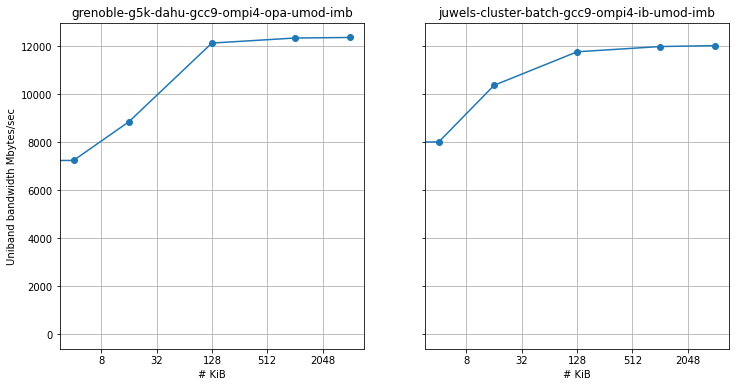

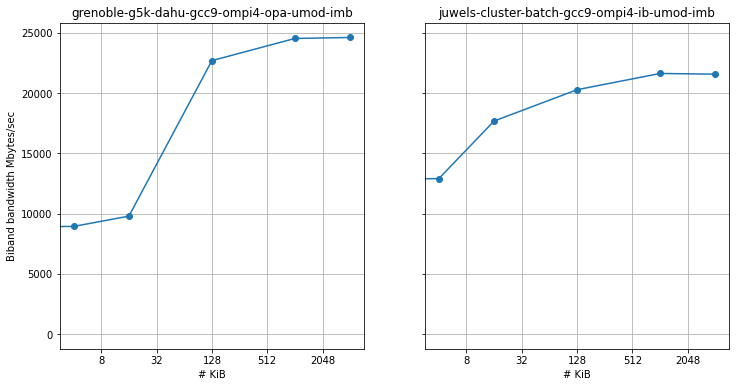

In [6]:
for (test_name, bm, perf_name, unit) in [('ImbPingpongTest', 'PingPong bandwidth', 'PingPong_bw_', ' Mbytes/sec'),
                                         ('ImbPingpongTest', 'PingPong latency', 'PingPong_lat_', ' usec'),
                                         ('ImbOneCoreTests_2', 'Uniband bandwidth', 'Uniband_bw_', ' Mbytes/sec'),
                                         ('ImbOneCoreTests_2', 'Biband bandwidth', 'Biband_bw_', ' Mbytes/sec'),]:
    perf_records = modules.utils.load_perf_logs(root=PERFLOG_DIR, extras=[], test=test_name, last=True)
    if perf_records is None:
        print('%s: no performance logs found' % test)
        continue
    nsystems = perf_records.groupby(['sysname', 'partition', 'environ']).ngroups
    fig, axes = plt.subplots(nrows=1, ncols=nsystems, figsize=(6 * nsystems, 6), sharey=True)
    if nsystems == 1:
        axes = [axes]
    for iplot, (spe, data) in enumerate(perf_records.groupby(['sysname', 'partition', 'environ'])):
        # filter to only PingPong_bw records
        # display(data)
        data = data.loc[data.perf_var.str.contains(perf_name), :]
        data['#bytes'] = data.perf_var.apply(lambda x: int(x.replace(perf_name, '')) / B2KiB)
        data.plot(ax=axes[iplot], x='#bytes', y='perf_value', style=['o-'], label='-'.join(spe), legend=None)
        axes[iplot].set_title('-'.join(spe))

    for ax in axes:
        ax.set_xticks(data['#bytes'])
        ax.set_xticklabels(data['#bytes'])
        ax.set_xlabel('# KiB')
        ax.set_ylabel(bm + unit)
        ax.set_xscale('log', base=2)
        if 'lat' in perf_name:
            ax.set_yscale('log', base=10)
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.grid(True, which='both')

## Create dataframe with MPI tasks, bandwidth and execution times for Uniband and Biband tests 

Here we read all the perflogs files for different number of nodes and create a data frame with partition name, number of MPI tasks, bandwidth and execution for Uniband and Biband tests.

In [7]:
metric_df = pd.DataFrame()
test_names = ['ImbOneCoreTests_*', 'ImbAllCoreTests_*']
perf_names = ['Uniband_bw_', 'Biband_bw_', 'Allgather_tp_', 'Allreduce_tp_', 'Alltoall_tp_']
for imetric, perf_name in enumerate(perf_names):
    for itest, test in enumerate(test_names):
        perf_records = modules.utils.load_perf_logs(root=PERFLOG_DIR, extras=['num_nodes', 'num_tasks'], test=test, last=True)
        if perf_records is None:
            print('%s: no performance logs found' % test)
            continue
        for isys, (spe, data) in enumerate(perf_records.groupby(['sysname', 'partition', 'environ'])): 
            # # filter to only metric records
            data = data.loc[data.perf_var.str.contains(perf_name), :]
            # Get row of maximum bandwiwth
            data_max = data[data['perf_value'] == data['perf_value'].max()]
            if metric_df.empty:
                metric_df = data_max.copy()
            else:
                metric_df = pd.concat([metric_df, data_max], axis=0)

## Maximum bandwidth vs MPI processes for Uniband and Biband tests

In [8]:
def plot_metric_with_tasks(metric_list, yscale_log=False):
    for isys, (spe, data) in enumerate(metric_df.groupby(['sysname', 'partition', 'environ'])):
        fig, axes = plt.subplots(nrows=1, ncols=len(metric_list), figsize=(6 * len(metric_list), 6), sharey=True)
        # axes = axes[np.newaxis, :]
        for imetric, (bm, perf_name, unit) in enumerate(metric_list):
            # filter to only metric records
            metric_data = data.loc[data.perf_var.str.contains(perf_name), :]
            metric_data.plot(ax=axes[imetric], x='num_tasks', y='perf_value', style=['o-'], label='-'.join(spe), legend=None)

            # format axis
            axes[imetric].set_xticks(data['num_tasks'])
            axes[imetric].set_xticklabels(data['num_tasks'])
            axes[imetric].set_title(bm)
            axes[imetric].set_xlabel('Number of MPI processes')
            axes[imetric].set_ylabel(unit)
            axes[imetric].set_xscale('log', base=2)
            if yscale_log:
                axes[imetric].set_yscale('log', base=10)
            axes[imetric].xaxis.set_major_formatter(ScalarFormatter())
            axes[imetric].grid(True, which='both')
            if imetric == len(metric_list) - 1:
                handles, labels = axes[imetric].get_legend_handles_labels()
                axes[imetric].legend()

The plots show the maximum bandwidths with message size for Uniband and Biband tests. 
Results are for the most-recent test on each system/partition/environment combination.

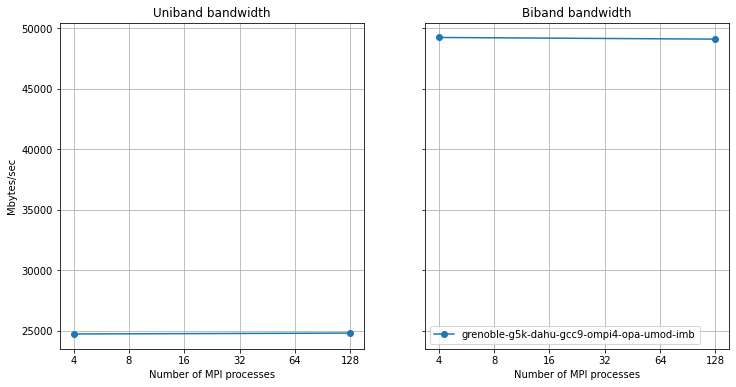

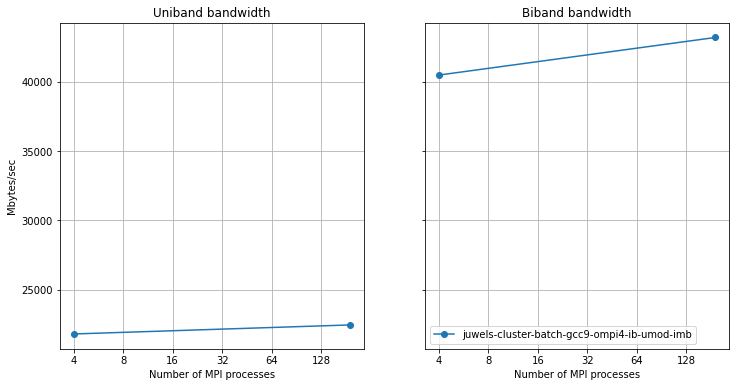

In [9]:
plot_metric_with_tasks([('Uniband bandwidth', 'Uniband_bw_', 'Mbytes/sec'), ('Biband bandwidth', 'Biband_bw_', 'Mbytes/sec'),])

## Execution time vs MPI processes for Allgather, Allreduce and Alltoall benchmarks

The plots show the execution times for message size of 1 MiB for Allgather, Allreduce and Alltoall benchmarks. 
Results are for the most-recent test on each system/partition/environment combination.

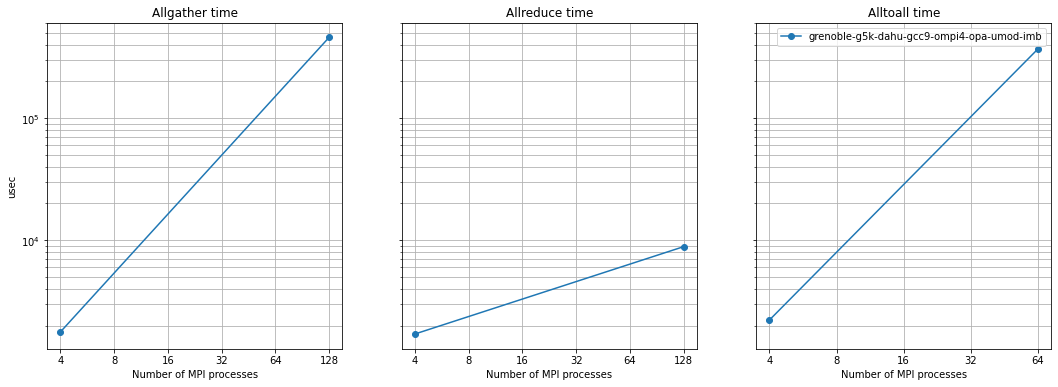

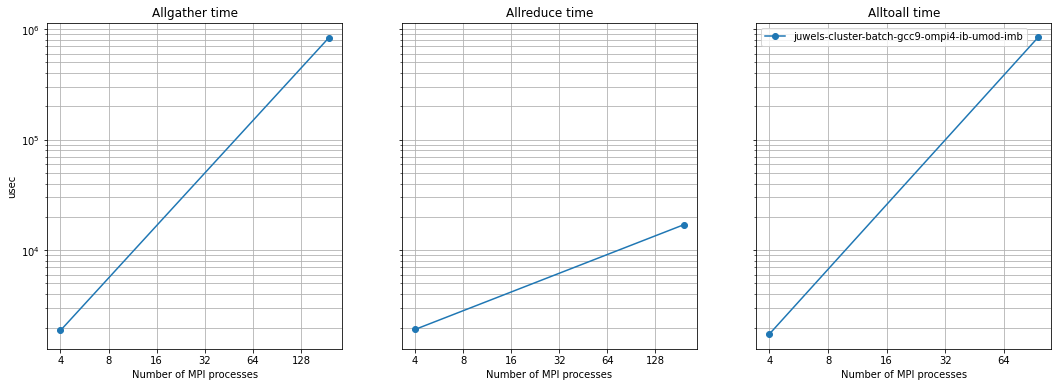

In [10]:
plot_metric_with_tasks([('Allgather time', 'Allgather_tp_', 'usec'), ('Allreduce time', 'Allreduce_tp_', 'usec'), ('Alltoall time', 'Alltoall_tp_', 'usec'),], yscale_log=True)